In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 16}
matplotlib.rc('font', **font)

### Tao initialization

In [4]:
from pytao import Tao

In [5]:
BEAMPATH = 'sc_hxr'

tao = Tao(f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init -noplot')

### For COL1, vary COL1[4] to introduce mis-match, then re-match with following:
#### data = COL1[1:4] (Twiss at ENDCOL1)
#### variable = q.COL1[5:12] (k1 of 8 quads downstream to QC104)

In [6]:
tao.cmd('SLD')
design_twiss_at_ENDCOL1 = tao.ele_twiss('ENDCOL1')

In [7]:
def optimize_twiss_cmds(dat_name, var_name, desired_twiss):
    """
        dat_name: STRING
        var_name: STRING
        desired_twiss : dictionary from tao.ele_twiss("ele_name")
    """
    
    out = f""" 
set global lattice_calc_on = F
set global optimizer = lmdif 

veto dat *
veto var *

set dat {dat_name}[1]|meas = {desired_twiss['beta_a']}
set dat {dat_name}[2]|meas = {desired_twiss['alpha_a']}
set dat {dat_name}[3]|meas = {desired_twiss['beta_b']}
set dat {dat_name}[4]|meas = {desired_twiss['alpha_b']}
!set dat {dat_name}[5]|meas = {desired_twiss['eta_x']}
!set dat {dat_name}[6]|meas = {desired_twiss['etap_x']}

use dat {dat_name}[1:4]
use var {var_name}

set global lattice_calc_on = T

!show top

run
run
run
run
run
run

!show dat {dat_name}
!show merit
"""
    return out.split('\n')

In [149]:
TWISS_CMDS = optimize_twiss_cmds("COL1", "q.COL1[5:10]", design_twiss_at_ENDCOL1 )

In [73]:
tao.cmds(TWISS_CMDS);

In [74]:
tao.cmd('SLD')
print('Merit:', tao.merit()[0])
tao.cmd('change ele QC104 k1 @-0.1')
print('Merit:', tao.merit()[0])
tao.cmd('SLD')
print('Merit:', tao.merit()[0])

Merit:   6.17853733598980E-28
Merit:   1.64677235596006E+04
Merit:   6.17853733598980E-28


## Attempt to rematch the optics

In [150]:
def twiss_optimizer(quad_name, k1_strength, reset_lat=False, debug=False):
    
    if debug:
        print(f'Rematching optics for {quad_name} with k1 = {k1_strength} 1/m^2')
    if reset_lat:
        tao.cmd('SLD')
        
    tao.cmd(f'change ele {quad_name} k1 @{k1_strength}')
    tao.cmds(TWISS_CMDS);
    merit = float(tao.merit()[0]) 
    
    assert merit < 1E-18, f"merit did NOT drop low enough {merit}!!"
        
    q4 = float(tao.var_v_array('q.COL1')[3].split(';')[3])
    
    q5 = float(tao.var_v_array('q.COL1')[4].split(';')[3])
    q6 = float(tao.var_v_array('q.COL1')[5].split(';')[3])
    q7 = float(tao.var_v_array('q.COL1')[6].split(';')[3])
    q8 = float(tao.var_v_array('q.COL1')[7].split(';')[3])
    q9 = float(tao.var_v_array('q.COL1')[8].split(';')[3])
    q10 = float(tao.var_v_array('q.COL1')[9].split(';')[3])
    
    q11 = float(tao.var_v_array('q.COL1')[10].split(';')[3])
    q12 = float(tao.var_v_array('q.COL1')[11].split(';')[3])
        
    return {"k1_QC104":q4, 
            "k1_QC105":q5, "k1_QC106":q6, "k1_QC107":q7, "k1_QC108":q8, 
            "k1_QC109":q9, "k1_QC110":q10, "k1_QC111":q11, "k1_QC112":q12}
    


In [76]:
twiss_optimizer('QC104', -2.0, reset_lat=False)
print('Merit:', tao.merit()[0])

Merit:   5.79643283502338E-28


#### Rematch over various QC104 strengths (as for emittance scan)

In [151]:
def append_k1_values(result_dic):
    k1_QC104_list.append(result_dic['k1_QC104']) 
    k1_QC105_list.append(result_dic['k1_QC105']) 
    k1_QC106_list.append(result_dic['k1_QC106']) 
    k1_QC107_list.append(result_dic['k1_QC107']) 
    k1_QC108_list.append(result_dic['k1_QC108']) 
    k1_QC109_list.append(result_dic['k1_QC109']) 
    k1_QC110_list.append(result_dic['k1_QC110']) 
    k1_QC111_list.append(result_dic['k1_QC111']) 
    k1_QC112_list.append(result_dic['k1_QC112']) 

In [152]:
k1_QC104_list = []
k1_QC105_list = []
k1_QC106_list = []
k1_QC107_list = []
k1_QC108_list = []
k1_QC109_list = []
k1_QC110_list = []
k1_QC111_list = []
k1_QC112_list = []

In [153]:
# Scan towards more negative k1
k1_QC104_array = np.linspace(-2, -10, 9)

tao.cmd('SLD')
for k1_QC104 in k1_QC104_array:
    result_dic = twiss_optimizer('QC104', k1_QC104, reset_lat=False, debug=True)
    append_k1_values(result_dic)

Rematching optics for QC104 with k1 = -2.0 1/m^2
Rematching optics for QC104 with k1 = -3.0 1/m^2
Rematching optics for QC104 with k1 = -4.0 1/m^2
Rematching optics for QC104 with k1 = -5.0 1/m^2
Rematching optics for QC104 with k1 = -6.0 1/m^2
Rematching optics for QC104 with k1 = -7.0 1/m^2
Rematching optics for QC104 with k1 = -8.0 1/m^2
Rematching optics for QC104 with k1 = -9.0 1/m^2
Rematching optics for QC104 with k1 = -10.0 1/m^2


In [155]:
# Scan towards more positive k1
k1_QC104_array2 = np.linspace(-1, 6, 8)

tao.cmd('SLD')
for k1_QC104 in k1_QC104_array2:
    result_dic = twiss_optimizer('QC104', k1_QC104, reset_lat=False, debug=True)
    append_k1_values(result_dic)

Rematching optics for QC104 with k1 = -1.0 1/m^2
Rematching optics for QC104 with k1 = 0.0 1/m^2
Rematching optics for QC104 with k1 = 1.0 1/m^2
Rematching optics for QC104 with k1 = 2.0 1/m^2
Rematching optics for QC104 with k1 = 3.0 1/m^2
Rematching optics for QC104 with k1 = 4.0 1/m^2
Rematching optics for QC104 with k1 = 5.0 1/m^2
Rematching optics for QC104 with k1 = 6.0 1/m^2


Text(0.5, 1.0, 'Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1')

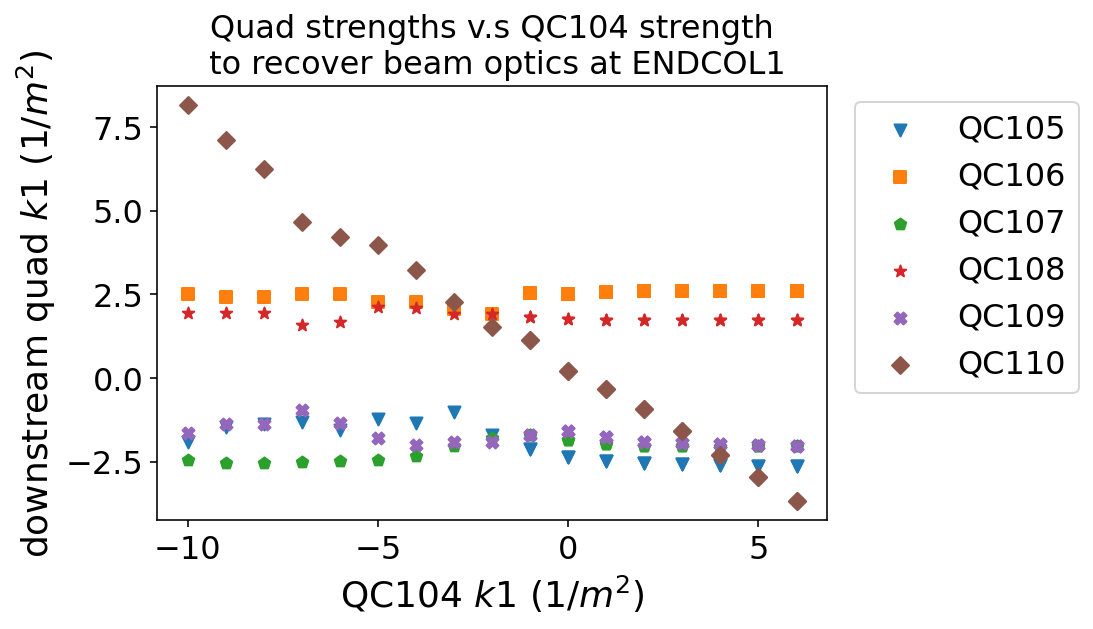

In [157]:
plt.scatter(k1_QC104_list, k1_QC105_list, label='QC105', marker="v")
plt.scatter(k1_QC104_list, k1_QC106_list, label='QC106', marker="s")
plt.scatter(k1_QC104_list, k1_QC107_list, label='QC107', marker="p")
plt.scatter(k1_QC104_list, k1_QC108_list, label='QC108', marker="*")
plt.scatter(k1_QC104_list, k1_QC109_list, label='QC109', marker="X")
plt.scatter(k1_QC104_list, k1_QC110_list, label='QC110', marker="D")
#plt.scatter(k1_QC104_list, k1_QC111_list, label='QC111', marker="P")
#plt.scatter(k1_QC104_list, k1_QC112_list, label='QC112', marker="+")


plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.xlabel(r'QC104 $k1 ~(1/m^2)$', fontsize=18)
plt.ylabel(r'downstream quad $k1 ~(1/m^2)$', fontsize=18)
plt.title('Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1', fontsize=16)

# Fine scan with only 4 quads

In [158]:
TWISS_CMDS = optimize_twiss_cmds("COL1", "q.COL1[5,7,8,10]", design_twiss_at_ENDCOL1 )

In [159]:
twiss_optimizer('QC104', -2.0, reset_lat=True)
print('Merit:', tao.merit()[0])

Merit:   3.15544362088405E-29


In [160]:
# Optimizer might fail if the initial condition is "unlucky"
# Either start with a closer initial condtion (at which solution has been found)
# or include more variables

twiss_optimizer('QC104', -2.5, reset_lat=False, debug=True)

Rematching optics for QC104 with k1 = -2.5 1/m^2


AssertionError: merit did NOT drop low enough 2.9678164037136!!

In [162]:
k1_QC104_list = []
k1_QC105_list = []
k1_QC106_list = []
k1_QC107_list = []
k1_QC108_list = []
k1_QC109_list = []
k1_QC110_list = []
k1_QC111_list = []
k1_QC112_list = []

In [163]:
# Scan towards more negative k1
k1_QC104_array = np.linspace(-2, -10, 33)

tao.cmd('SLD')
for k1_QC104 in k1_QC104_array:
    result_dic = twiss_optimizer('QC104', k1_QC104, reset_lat=False, debug=True)
    append_k1_values(result_dic)

Rematching optics for QC104 with k1 = -2.0 1/m^2
Rematching optics for QC104 with k1 = -2.25 1/m^2
Rematching optics for QC104 with k1 = -2.5 1/m^2
Rematching optics for QC104 with k1 = -2.75 1/m^2
Rematching optics for QC104 with k1 = -3.0 1/m^2
Rematching optics for QC104 with k1 = -3.25 1/m^2
Rematching optics for QC104 with k1 = -3.5 1/m^2
Rematching optics for QC104 with k1 = -3.75 1/m^2
Rematching optics for QC104 with k1 = -4.0 1/m^2
Rematching optics for QC104 with k1 = -4.25 1/m^2
Rematching optics for QC104 with k1 = -4.5 1/m^2
Rematching optics for QC104 with k1 = -4.75 1/m^2
Rematching optics for QC104 with k1 = -5.0 1/m^2
Rematching optics for QC104 with k1 = -5.25 1/m^2
Rematching optics for QC104 with k1 = -5.5 1/m^2
Rematching optics for QC104 with k1 = -5.75 1/m^2
Rematching optics for QC104 with k1 = -6.0 1/m^2
Rematching optics for QC104 with k1 = -6.25 1/m^2
Rematching optics for QC104 with k1 = -6.5 1/m^2
Rematching optics for QC104 with k1 = -6.75 1/m^2
Rematching

In [164]:
# Scan towards more positive k1
k1_QC104_array2 = np.linspace(-1.75, 6, 32)

tao.cmd('SLD')
for k1_QC104 in k1_QC104_array2:
    result_dic = twiss_optimizer('QC104', k1_QC104, reset_lat=False, debug=True)
    append_k1_values(result_dic)

Rematching optics for QC104 with k1 = -1.75 1/m^2
Rematching optics for QC104 with k1 = -1.5 1/m^2
Rematching optics for QC104 with k1 = -1.25 1/m^2
Rematching optics for QC104 with k1 = -1.0 1/m^2
Rematching optics for QC104 with k1 = -0.75 1/m^2
Rematching optics for QC104 with k1 = -0.5 1/m^2
Rematching optics for QC104 with k1 = -0.25 1/m^2
Rematching optics for QC104 with k1 = 0.0 1/m^2
Rematching optics for QC104 with k1 = 0.25 1/m^2
Rematching optics for QC104 with k1 = 0.5 1/m^2
Rematching optics for QC104 with k1 = 0.75 1/m^2
Rematching optics for QC104 with k1 = 1.0 1/m^2
Rematching optics for QC104 with k1 = 1.25 1/m^2
Rematching optics for QC104 with k1 = 1.5 1/m^2
Rematching optics for QC104 with k1 = 1.75 1/m^2
Rematching optics for QC104 with k1 = 2.0 1/m^2
Rematching optics for QC104 with k1 = 2.25 1/m^2
Rematching optics for QC104 with k1 = 2.5 1/m^2
Rematching optics for QC104 with k1 = 2.75 1/m^2
Rematching optics for QC104 with k1 = 3.0 1/m^2
Rematching optics for Q

Text(0.5, 1.0, 'Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1')

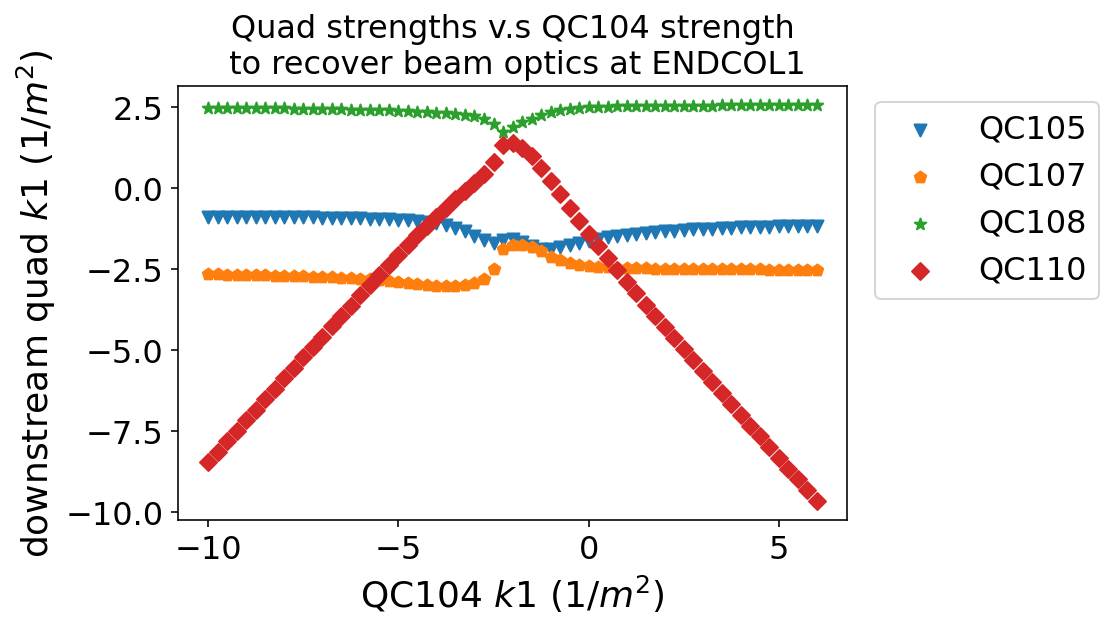

In [165]:
plt.scatter(k1_QC104_list, k1_QC105_list, label='QC105', marker="v")
#plt.scatter(k1_QC104_list, k1_QC106_list, label='QC106', marker="s")
plt.scatter(k1_QC104_list, k1_QC107_list, label='QC107', marker="p")
plt.scatter(k1_QC104_list, k1_QC108_list, label='QC108', marker="*")
#plt.scatter(k1_QC104_list, k1_QC109_list, label='QC109', marker="X")
plt.scatter(k1_QC104_list, k1_QC110_list, label='QC110', marker="D")
#plt.scatter(k1_QC104_list, k1_QC111_list, label='QC111', marker="P")
#plt.scatter(k1_QC104_list, k1_QC112_list, label='QC112', marker="+")


plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.xlabel(r'QC104 $k1 ~(1/m^2)$', fontsize=18)
plt.ylabel(r'downstream quad $k1 ~(1/m^2)$', fontsize=18)
plt.title('Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1', fontsize=16)

### Interpolation / Polyfit for simple formulas of k1_QC1xx(k1_QC104)
#### (To be editted)

In [168]:
from scipy import interpolate

In [176]:
f5 = interpolate.interp1d(k1_QC104_list, k1_QC105_list)
f7 = interpolate.interp1d(k1_QC104_list, k1_QC107_list)
f8 = interpolate.interp1d(k1_QC104_list, k1_QC108_list)
f10 = interpolate.interp1d(k1_QC104_list, k1_QC110_list)


q4_fine = np.linspace(-10,6,101)
q5_fine = f5(q4_fine)
q7_fine = f7(q4_fine)
q8_fine = f8(q4_fine)
q10_fine = f10(q4_fine)

Text(0.5, 1.0, 'Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1')

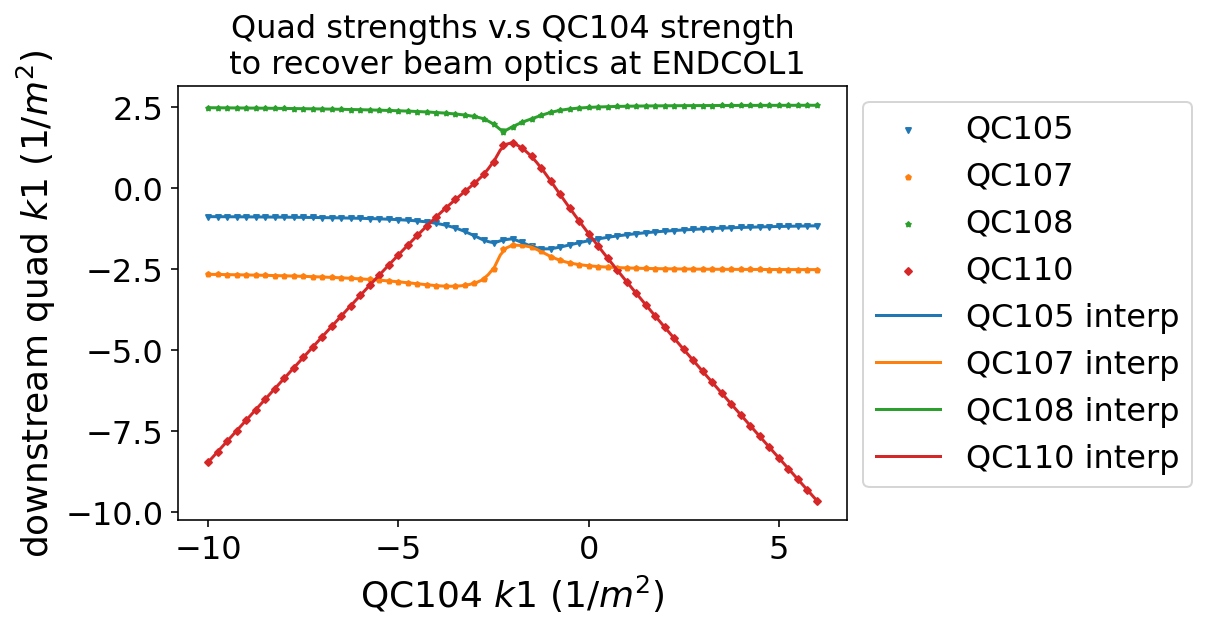

In [189]:
plt.scatter(k1_QC104_list, k1_QC105_list, label='QC105', marker="v", s=6)
plt.scatter(k1_QC104_list, k1_QC107_list, label='QC107', marker="p", s=6)
plt.scatter(k1_QC104_list, k1_QC108_list, label='QC108', marker="*", s=6)
plt.scatter(k1_QC104_list, k1_QC110_list, label='QC110', marker="D", s=6)

plt.plot(q4_fine, q5_fine, label='QC105 interp')
plt.plot(q4_fine, q7_fine, label='QC107 interp')
plt.plot(q4_fine, q8_fine, label='QC108 interp')
plt.plot(q4_fine, q10_fine, label='QC110 interp')


plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel(r'QC104 $k1 ~(1/m^2)$', fontsize=18)
plt.ylabel(r'downstream quad $k1 ~(1/m^2)$', fontsize=18)
plt.title('Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1', fontsize=16)

In [180]:
z5 = np.polyfit(k1_QC104_list, k1_QC105_list, 6)
poly5 = np.poly1d(z5)
z7 = np.polyfit(k1_QC104_list, k1_QC107_list, 6)
poly7 = np.poly1d(z7)
z8 = np.polyfit(k1_QC104_list, k1_QC108_list, 6)
poly8 = np.poly1d(z8)
z10 = np.polyfit(k1_QC104_list, k1_QC110_list, 6)
poly10 = np.poly1d(z10)

q4_fine = np.linspace(-10,6,101)
q5_poly = poly5(q4_fine)
q7_poly = poly7(q4_fine)
q8_poly = poly8(q4_fine)
q10_poly = poly10(q4_fine)

Text(0.5, 1.0, 'Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1')

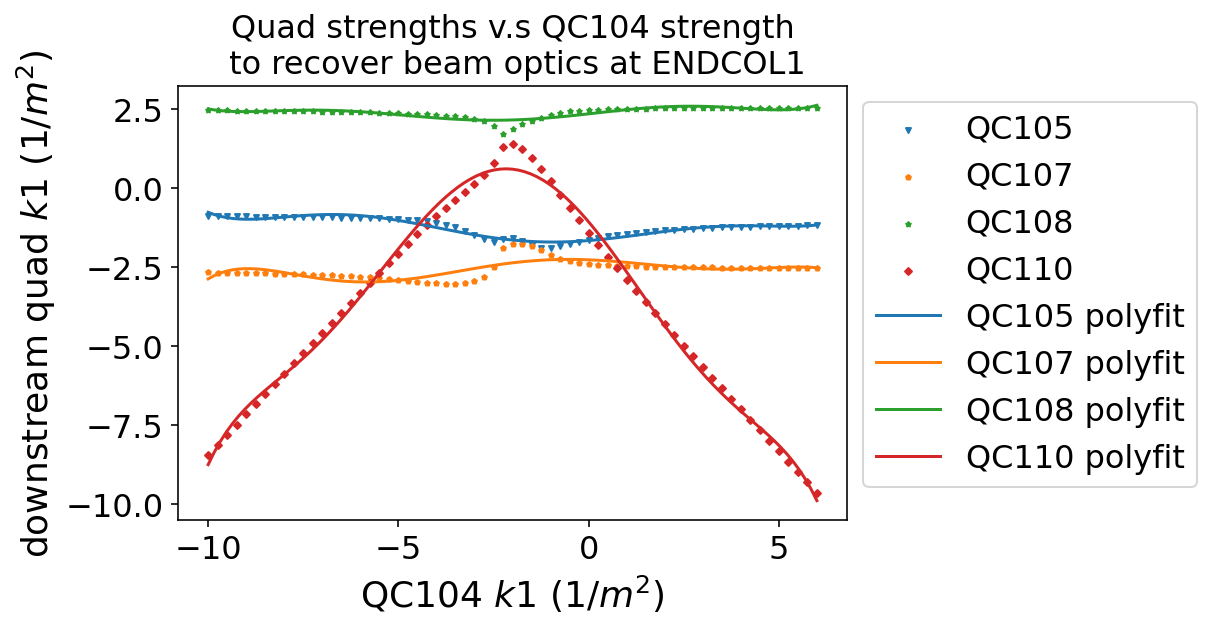

In [187]:
plt.scatter(k1_QC104_list, k1_QC105_list, label='QC105', marker="v", s=6)
plt.scatter(k1_QC104_list, k1_QC107_list, label='QC107', marker="p", s=6)
plt.scatter(k1_QC104_list, k1_QC108_list, label='QC108', marker="*", s=6)
plt.scatter(k1_QC104_list, k1_QC110_list, label='QC110', marker="D", s=6)

plt.plot(q4_fine, q5_poly, label='QC105 polyfit')
plt.plot(q4_fine, q7_poly, label='QC107 polyfit')
plt.plot(q4_fine, q8_poly, label='QC108 polyfit')
plt.plot(q4_fine, q10_poly, label='QC110 polyfit')


plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel(r'QC104 $k1 ~(1/m^2)$', fontsize=18)
plt.ylabel(r'downstream quad $k1 ~(1/m^2)$', fontsize=18)
plt.title('Quad strengths v.s QC104 strength\n to recover beam optics at ENDCOL1', fontsize=16)

# Below are scratchs 

In [ ]:
def get_COL1_quad_strengths(list1):
    
    q4 = float(tao.cmd("python var q.COL1[4]")[0][20:])
    
    q5 = float(tao.cmd("python var q.COL1[5]")[0][20:])
    q6 = float(tao.cmd("python var q.COL1[6]")[0][20:])
    q7 = float(tao.cmd("python var q.COL1[7]")[0][20:])
    q8 = float(tao.cmd("python var q.COL1[8]")[0][20:])
    q9 = float(tao.cmd("python var q.COL1[9]")[0][20:])
    q10 = float(tao.cmd("python var q.COL1[10]")[0][20:])
    
    list1.append([q4, q5, q6, q7, q8, q9, q10])
    
    return None